In [ ]:
import torch
from torch import nn, optim
from torchvision import models
import torch.nn as nn


import numpy as np
# from sklearn.model_selection import train_test_split
import torch.utils.data
from torch import optim

import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt

import cv2 as cv
index=0
max_pad_len=174#174


In [ ]:
fulldatasetpath = '/content/drive/My Drive/your image path file/'
metadata = pd.read_csv('/content/drive/My Drive/UrbanSound8K.csv') 
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
#read saved all images and create dataframe (image_features(ndarray), image class, folder index( image  corresponding to sound files folder index))
def get_data():
    count=0

    features = []

    for index, row in metadata.iterrows():
            if count==8700:
                break
            
            class_label = row["classID"]
            data = cv.imread(fulldatasetpath+str(index)+".png")## your  images  path 
            print(len(data))
            features.append([data, class_label,row["fold"]])
           
            print("extracted files: ",index)
            count+=1
    # Convert into a Panda dataframe
    featuresdf = pd.DataFrame(features, columns=['feature', 'class_label','fold'])


    print('Finished feature extraction from ', len(featuresdf), ' files')

    return featuresdf

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# don't run for 10 fold classification
data=get_data().sample(frac=1)


In [ ]:
#you must be run this, if you want to 10 fold cross validation 
data=data.to_numpy()


In [ ]:
# if you want 10 fold valitadion don't run this part !!!!!
data=data.to_numpy()
#create data

test_data=data[:2100,:]

train_data=data[2100:8700,:]
print("len:     ",len(test_data),len(train_data))
data=0


len:      2100 6600


In [ ]:
#don't run this part, if you want 10 fold cross validation !!!!!

trainloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(np.array(train_data[:,0].tolist()).reshape((len(train_data),3,299,299))).type(torch.FloatTensor)
                                                                        , torch.from_numpy(np.array([*train_data[:,1]])).type(torch.LongTensor)),
                                                                            batch_size=25, shuffle=False,num_workers=1)

train_data=0
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(np.array(test_data[:,0].tolist()).reshape((len(test_data),3,299,299))).type(torch.FloatTensor)
                                                                        , torch.from_numpy(np.array([*test_data[:,1]])).type(torch.LongTensor)),
                                                                            batch_size=25, shuffle=False,num_workers=1)

test_data=0


In [ ]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride=1, bias=True):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Stem(nn.Module):
    def __init__(self, in_channels):
        super(Stem, self).__init__()
        self.features = nn.Sequential(
            Conv2d(in_channels, 32, 3, stride=2, padding=0, bias=False), # 149 x 149 x 32
            Conv2d(32, 32, 3, stride=1, padding=0, bias=False), # 147 x 147 x 32
            Conv2d(32, 64, 3, stride=1, padding=1, bias=False), # 147 x 147 x 64
            nn.MaxPool2d(3, stride=2, padding=0), # 73 x 73 x 64
            Conv2d(64, 80, 1, stride=1, padding=0, bias=False), # 73 x 73 x 80
            Conv2d(80, 192, 3, stride=1, padding=0, bias=False), # 71 x 71 x 192
            nn.MaxPool2d(3, stride=2, padding=0), # 35 x 35 x 192
        )
        self.branch_0 = Conv2d(192, 96, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(192, 48, 1, stride=1, padding=0, bias=False),
            Conv2d(48, 64, 5, stride=1, padding=2, bias=False),
        )
        self.branch_2 = nn.Sequential(
            Conv2d(192, 64, 1, stride=1, padding=0, bias=False),
            Conv2d(64, 96, 3, stride=1, padding=1, bias=False),
            Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
        )
        self.branch_3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            Conv2d(192, 64, 1, stride=1, padding=0, bias=False)
        )
    def forward(self, x):
        x = self.features(x)
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        return torch.cat((x0, x1, x2, x3), dim=1)


class Inception_ResNet_A(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super(Inception_ResNet_A, self).__init__()
        self.scale = scale
        self.branch_0 = Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False),
            Conv2d(32, 32, 3, stride=1, padding=1, bias=False)
        )
        self.branch_2 = nn.Sequential(
            Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False),
            Conv2d(32, 48, 3, stride=1, padding=1, bias=False),
            Conv2d(48, 64, 3, stride=1, padding=1, bias=False)
        )
        self.conv = nn.Conv2d(128, 320, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x_res = torch.cat((x0, x1, x2), dim=1)
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)



class Reduction_A(nn.Module):
    # 35 -> 17
    def __init__(self, in_channels, k, l, m, n):
        super(Reduction_A, self).__init__()
        self.branch_0 = Conv2d(in_channels, n, 3, stride=2, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, k, 1, stride=1, padding=0, bias=False),
            Conv2d(k, l, 3, stride=1, padding=1, bias=False),
            Conv2d(l, m, 3, stride=2, padding=0, bias=False),
        )
        self.branch_2 = nn.MaxPool2d(3, stride=2, padding=0)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        return torch.cat((x0, x1, x2), dim=1) # 17 x 17 x 1024


class Inception_ResNet_B(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super(Inception_ResNet_B, self).__init__()
        self.scale = scale
        self.branch_0 = Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 128, 1, stride=1, padding=0, bias=False),
            Conv2d(128, 160, (1, 7), stride=1, padding=(0, 3), bias=False),
            Conv2d(160, 192, (7, 1), stride=1, padding=(3, 0), bias=False)
        )
        self.conv = nn.Conv2d(384, 1088, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)


class Reduciton_B(nn.Module):
    def __init__(self, in_channels):
        super(Reduciton_B, self).__init__()
        self.branch_0 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 384, 3, stride=2, padding=0, bias=False)
        )
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 288, 3, stride=2, padding=0, bias=False),
        )
        self.branch_2 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 288, 3, stride=1, padding=1, bias=False),
            Conv2d(288, 320, 3, stride=2, padding=0, bias=False)
        )
        self.branch_3 = nn.MaxPool2d(3, stride=2, padding=0)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        return torch.cat((x0, x1, x2, x3), dim=1)


class Inception_ResNet_C(nn.Module):
    def __init__(self, in_channels, scale=1.0, activation=True):
        super(Inception_ResNet_C, self).__init__()
        self.scale = scale
        self.activation = activation
        self.branch_0 = Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False),
            Conv2d(192, 224, (1, 3), stride=1, padding=(0, 1), bias=False),
            Conv2d(224, 256, (3, 1), stride=1, padding=(1, 0), bias=False)
        )
        self.conv = nn.Conv2d(448, 2080, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        if self.activation:
            return self.relu(x + self.scale * x_res)
        return x + self.scale * x_res


class Inception_ResNet_D(nn.Module):
    def __init__(self, in_channels, scale=1.0, activation=True):
        super(Inception_ResNet_D, self).__init__()
        self.scale = scale
        self.activation = activation
        self.branch_0 = Conv2d(in_channels, 128, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 128, 1, stride=1, padding=0, bias=False),
            Conv2d(128, 256, (1, 3), stride=1, padding=(0, 1), bias=False),
            Conv2d(256, 256, (3, 1), stride=1, padding=(1, 0), bias=False)
        )
        self.conv = nn.Conv2d(512, 2080, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        if self.activation:
            return self.relu(x + self.scale * x_res)
        return x + self.scale * x_res

class Inception_ResNetv2(nn.Module):
    def __init__(self, in_channels=3, classes=1000, k=256, l=256, m=384, n=384):
        super(Inception_ResNetv2, self).__init__()
        blocks = []
        blocks.append(Stem(in_channels))
        for i in range(10):
            blocks.append(Inception_ResNet_A(320, 0.5))
        blocks.append(Reduction_A(320, k, l, m, n))
        for i in range(20):
            blocks.append(Inception_ResNet_B(1088, 0.10))
        blocks.append(Reduciton_B(1088))
        for i in range(9):
            blocks.append(Inception_ResNet_C(2080, 0.20))

            
        blocks.append(Inception_ResNet_C(2080, activation=False))
        blocks.append(Inception_ResNet_C(2080, 0.25))
        self.features = nn.Sequential(*blocks)
        self.conv = Conv2d(2080, 1536, 1, stride=1, padding=0, bias=False)
        self.global_average_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(1536, classes)

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.global_average_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x



In [ ]:
model = Inception_ResNetv2()

In [ ]:

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device);


epochs = 60
# steps = 0
# print_every = 5
running_loss =[]
train_acc=[]
tesc_acc = []
accuracy = []
liste=range(1,11)
for epoch in range(epochs):
  
    #------------------------------------------------------------------------------------10 fold cross validation loops------------------------------------------------------------------------------------------------------------------------------
    # for loops in range(0,10):     

    #     print("test folder: ",liste[loops])
    #     test_data = data[data.fold==liste[loops]].to_numpy()  # 2200
    #     train_data = data[data.fold!=liste[loops]].to_numpy()  # 2200:8600

    #     #x_train = np.array(train_data[:, 0].tolist())
    #     #x_test = np.array(test_data[:, 0].tolist())

    #     # %% Device config

    #     trainloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(np.array(train_data[:,0].tolist()).reshape((len(train_data),3,299,299))).type(torch.FloatTensor)
    #                                                                     , torch.from_numpy(np.array([*train_data[:,1]])).type(torch.LongTensor)),
    #                                                                         batch_size=25, shuffle=False)
           
                                         
            

    #     train_data = 0
    #     testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.from_numpy(np.array(test_data[:,0].tolist()).reshape((len(test_data),3,299,299))).type(torch.FloatTensor)
    #                                                                     , torch.from_numpy(np.array([*test_data[:,1]])).type(torch.LongTensor))
    #                                                                                 ,batch_size = 25, shuffle = False )
    #---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
            
           
        print("epochs: ",epoch)                                
        correct = 0
        total = 0
        model.train()
        test_data = 0
        total_step = len(trainloader)
        for i,(images, labels) in enumerate(trainloader):
            # steps += 1
            # print("train_loader: ",i)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            # images = images.view(5, 224, 224, 3)

            outputs = model.forward(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.item())

            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if i % 66 == 0:
                 print("epoch: {} {}/{}".format(epoch, i, total_step))
        print("Accuracy train %.2f %%" % (100 * correct / total))
        train_acc.append(100 * correct / total)

        # if steps % print_every == 0:

        correct = 0
        total = 0
        model.eval()
        for images, labels in testloader:
            optimizer.zero_grad()
            with torch.no_grad():
                images, labels = images.to(device), labels.to(device)
                # images = images.view(5, 224, 224, 3)
                output = model.forward(images)

                _, predicted = torch.max(output.data, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print("Accuracy test %.2f %%" % (100 * correct / total))
        tesc_acc.append(100 * correct / total)





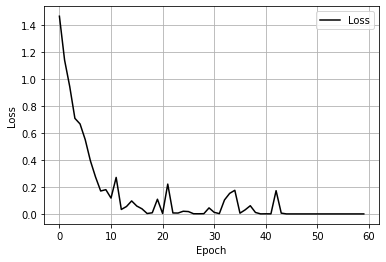

<Figure size 800x800 with 0 Axes>

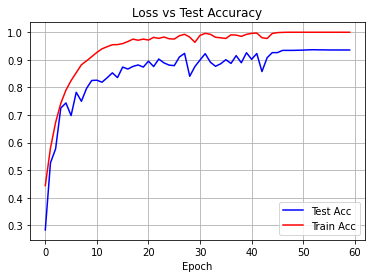

loss [1.464338779449463, 1.1398983001708984, 0.9433181285858154, 0.7080535888671875, 0.6663625836372375, 0.550569474697113, 0.39434006810188293, 0.2736141085624695, 0.16975151002407074, 0.1797308772802353, 0.11731527000665665, 0.2703120708465576, 0.033072032034397125, 0.05483953654766083, 0.09626056998968124, 0.05827377364039421, 0.03783517703413963, 0.0031584929674863815, 0.00834924727678299, 0.10875116288661957, 0.0032760619651526213, 0.22083573043346405, 0.007012844085693359, 0.006473788991570473, 0.019781265407800674, 0.01746009849011898, 0.0013489914126694202, 0.0010699463309720159, 0.0018183707725256681, 0.04464998096227646, 0.011709518730640411, 0.0022491835989058018, 0.10347608476877213, 0.1522529423236847, 0.17501682043075562, 0.005484657362103462, 0.030085792765021324, 0.060684241354465485, 0.010817489586770535, 0.00027881620917469263, 0.0008309936383739114, 0.0004410171532072127, 0.17216593027114868, 0.005783195607364178, 4.4784545025322586e-05, 3.971099795307964e-05, 1.3351

In [ ]:
plt.plot(running_loss, label="Loss", color="black") 
# ax2 = a8x1.twinx()
plt.legend()
# ax2.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.show()
plt.plot((np.array(tesc_acc) / 100).tolist(), label="Test Acc", color="blue")
plt.plot((np.array(train_acc) / 100).tolist(), label="Train Acc", color="red")
plt.legend()
# ax2.legend()
plt.xlabel('Epoch'
# fig.tight_layout()
plt.title("Loss vs Test Accuracy")
plt.grid()
plt.show()

print("loss",running_loss)
print("test",(np.array(tesc_acc) / 100).tolist())
print("train",(np.array(train_acc) / 100).tolist())
